# NaiveBayes

## Librerias Utilizadas

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics as mt
import calendar

In [8]:
import warnings
warnings.filterwarnings("ignore")

## Limpieza de datos

Transformamos las variables necesarias a formato numérico pedido por el modelo

In [26]:
def procesar_csv(df):
    from sklearn import preprocessing
    
    # Convertirmos las columnas origin y destination a variables numericas 
    le = preprocessing.LabelEncoder()
    ciudades = ((pd.concat([df['origin'], df['destination']], ignore_index = True).drop_duplicates()).reset_index())[0]
    le.fit(ciudades)
    
    origin_as_int = le.fit_transform(df['origin'])
    destination_as_int = le.fit_transform(df["destination"])
    
    df["origin_int"] = origin_as_int
    df.drop('origin', axis=1, inplace=True)
    
    df["destination_int"] = destination_as_int
    df.drop('destination', axis=1, inplace=True)

    # Transformamos Columnas Continuas a Discretas
    revenues_usd_discr = pd.qcut(df["revenues_usd"], 10, [1,2,3,4,5,6,7,8,9,10] )
    df["revenues_usd_discr"] = revenues_usd_discr
    df.drop('revenues_usd', axis=1, inplace=True)
    
    # Cambiamos el formato del date y departure_time para saber el mes de la compra y el horario en el que se compra
    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    df["mes"] = pd.DatetimeIndex(df["date"]).month
    
    df.departure_time = pd.to_datetime(df.departure_time, errors='coerce')
    bins = [0,12,18,24]
    labels = ["Mañana","Tarde","Noche"]
    le.fit(labels)
    df["hora"] = pd.DatetimeIndex(df["departure_time"]).hour
    #df['horario'] = pd.cut(df["departure_time"].dt.hour, bins, labels=labels, right=False)
    #df['horario'] = le.fit_transform(df["horario"])
    
    df.drop('departure_time', axis=1, inplace=True)
    df.drop('date', axis=1, inplace=True)
    
    
    le.fit(df["fligth_number"])
    df["fligth_number"] = le.fit_transform(df["fligth_number"])

    
    # Eliminar columnas sin uso
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # retornamos el data frame modificado sin valore nulos.
    return df.dropna()

In [27]:
# Leemos los datos
df = pd.read_csv("ALUMNOS-trainData.csv")
df_procesado = df.copy()

# transformamos los datos a binarios
df_procesado["Labels"] = np.where(df_procesado["noshow"] >= 4, 1,0)

# Procesamos los datos con la funcion procesar_csv()
df_procesado = procesar_csv(df_procesado)

# Definimos nuestra columna target
target = df_procesado['Labels']

# La eliminamos del dataframe
df_procesado.drop('noshow', axis=1, inplace=True)
df_procesado.drop('Labels', axis=1, inplace=True)

In [28]:
df_procesado.columns

Index(['fligth_number', 'distance', 'denied_boarding', 'pax_midlow',
       'pax_high', 'pax_midhigh', 'pax_low', 'pax_freqflyer', 'group_bookings',
       'out_of_stock', 'dom_cnx', 'int_cnx', 'p2p', 'capacity', 'bookings',
       'origin_int', 'destination_int', 'revenues_usd_discr', 'mes', 'hora'],
      dtype='object')

,fligth_number
3789,1729
3784,1700
3436,1690
3437,1682
3591,1682
...,...
2878,1
3102,1
3353,1
2497,1


<AxesSubplot:title={'center':'fligth_number'}>

,distance
366,33768
586,30177
1106,18317
873,16216
1225,14991
...,...
4785,1
395,1
1437,1
249,1


<AxesSubplot:title={'center':'distance'}>

,denied_boarding
0,984720
1,3822
2,3278
3,1782
4,1566
5,886
6,763
7,470
8,346
9,191


<AxesSubplot:title={'center':'denied_boarding'}>

,pax_midlow
0,33891
1,14774
2,13992
3,10470
85,10193
...,...
307,1
293,1
295,1
303,1


<AxesSubplot:title={'center':'pax_midlow'}>

,pax_high
0,395069
1,135807
2,103279
3,66656
4,53110
...,...
137,1
167,1
145,1
132,1


<AxesSubplot:title={'center':'pax_high'}>

,pax_midhigh
0,290008
1,110794
2,88901
3,67798
4,56664
...,...
154,1
182,1
141,1
147,1


<AxesSubplot:title={'center':'pax_midhigh'}>

,pax_low
0,94306
51,10214
54,10146
49,10117
57,10104
...,...
285,1
267,1
272,1
274,1


<AxesSubplot:title={'center':'pax_low'}>

,pax_freqflyer
8,40400
7,40358
6,40339
9,40292
10,39196
...,...
236,1
210,1
230,1
216,1


<AxesSubplot:title={'center':'pax_freqflyer'}>

,group_bookings
0,832218
1,11335
2,8394
10,7948
20,5736
...,...
193,1
205,1
187,1
228,1


<AxesSubplot:title={'center':'group_bookings'}>

,out_of_stock
0,902254
1,96218


<AxesSubplot:title={'center':'out_of_stock'}>

,dom_cnx
0,286334
1,29963
2,26797
3,21540
4,20672
...,...
242,1
209,1
219,1
246,1


<AxesSubplot:title={'center':'dom_cnx'}>

,int_cnx
0,263705
1,66009
2,62270
3,42354
4,38385
...,...
316,1
310,1
333,1
357,1


<AxesSubplot:title={'center':'int_cnx'}>

,p2p
0,32715
82,6582
81,6493
83,6485
87,6471
...,...
401,1
519,1
490,1
395,1


<AxesSubplot:title={'center':'p2p'}>

,capacity
174.000000,402063
144.000000,199905
220.000000,116525
168.000000,67504
218.000000,49406
...,...
269.000000,1
66.000000,1
299.000000,1
292.000000,1


<AxesSubplot:title={'center':'capacity'}>

,bookings
138,6397
129,6333
131,6321
126,6304
128,6269
...,...
571,1
554,1
573,1
574,1


<AxesSubplot:title={'center':'bookings'}>

,origin_int
122,94089
79,91877
52,86472
27,77450
21,57901
...,...
74,38
106,31
95,31
137,10


<AxesSubplot:title={'center':'origin_int'}>

,destination_int
125,94575
81,91578
54,86397
27,77330
21,58162
...,...
76,31
149,10
140,9
118,1


<AxesSubplot:title={'center':'destination_int'}>

,revenues_usd_discr
9,99913
10,99898
4,99889
6,99888
5,99881
7,99877
3,99875
8,99870
2,99836
1,99545


<AxesSubplot:title={'center':'revenues_usd_discr'}>

,mes
1,99822
7,96566
12,92746
10,92291
11,89482
9,87308
6,84225
5,80616
3,72287
2,69694


<AxesSubplot:title={'center':'mes'}>

,hora
8.0,65554
19.0,60698
12.0,60107
15.0,57241
10.0,56923
17.0,56023
9.0,53732
18.0,53290
20.0,53051
7.0,52256


<AxesSubplot:title={'center':'hora'}>

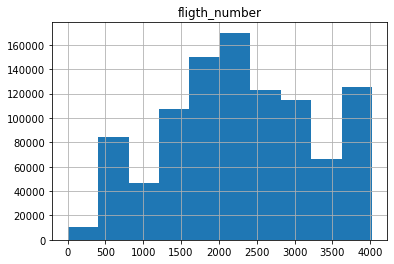

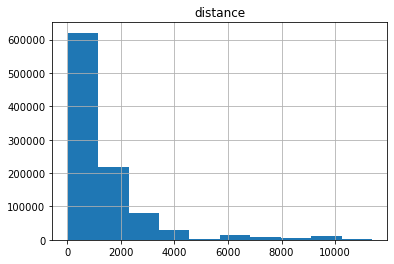

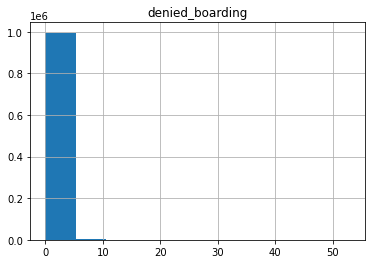

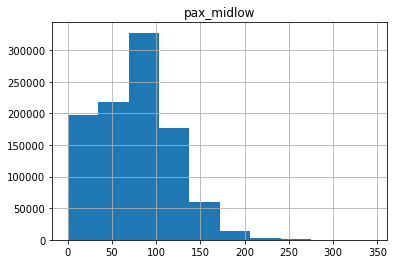

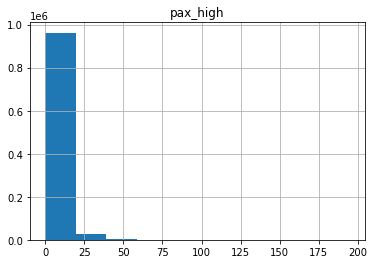

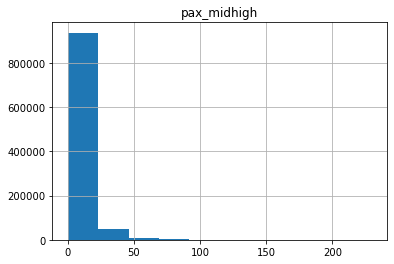

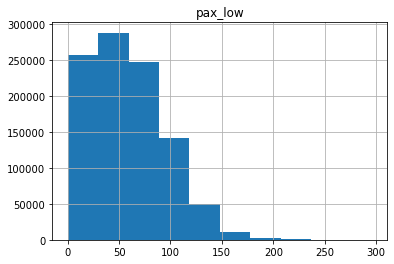

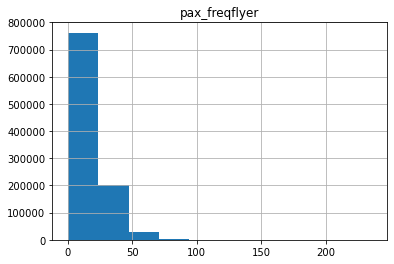

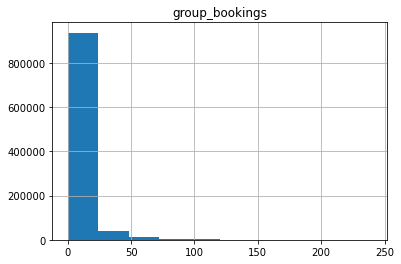

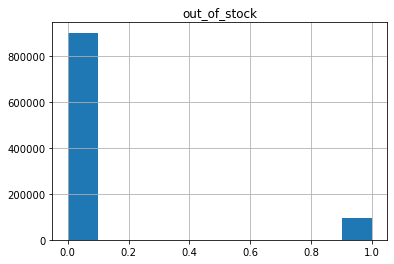

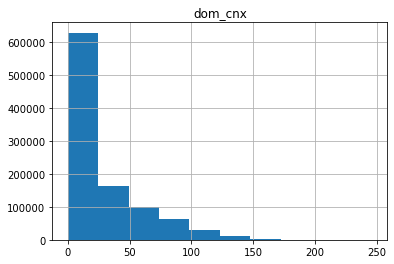

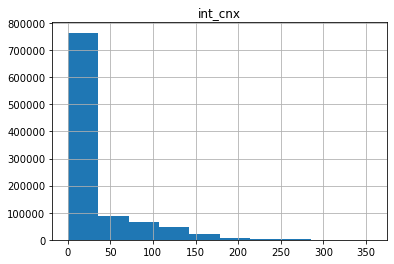

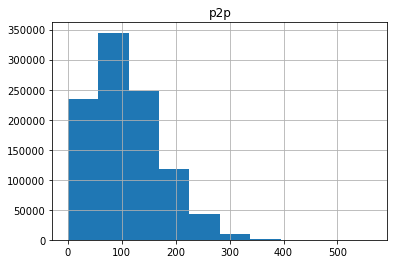

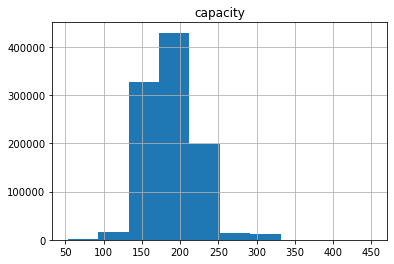

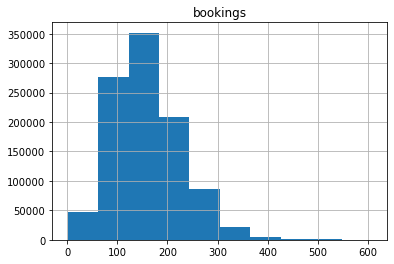

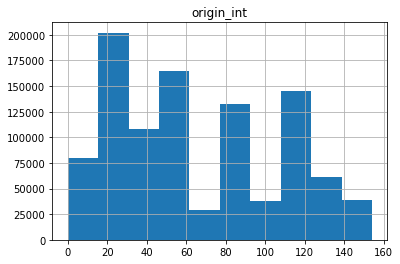

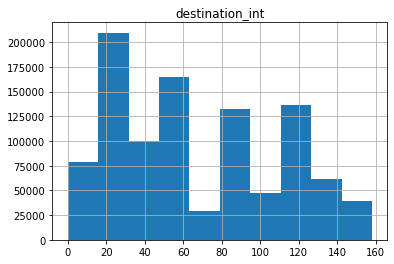

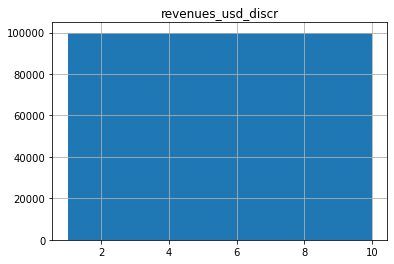

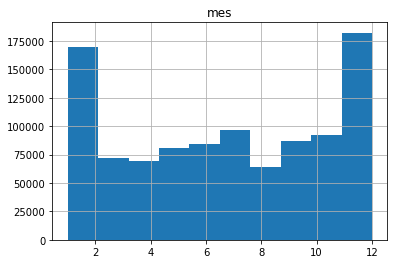

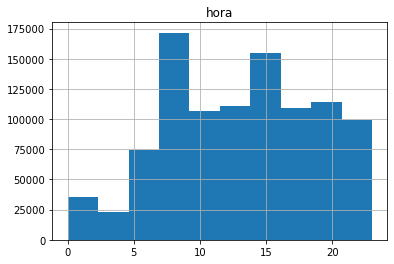

In [29]:
for i in df_procesado.columns:
    plt.figure()
    plt.title(i)
    display(pd.DataFrame(df_procesado[i].value_counts()), df_procesado[i].hist())

,0,1,2,3
0,"AxesSubplot(0.125,0.758226;0.158163x0.121774)","AxesSubplot(0.330612,0.758226;0.158163x0.121774)","AxesSubplot(0.536224,0.758226;0.158163x0.121774)","AxesSubplot(0.741837,0.758226;0.158163x0.121774)"
1,"AxesSubplot(0.125,0.599919;0.158163x0.121774)","AxesSubplot(0.330612,0.599919;0.158163x0.121774)","AxesSubplot(0.536224,0.599919;0.158163x0.121774)","AxesSubplot(0.741837,0.599919;0.158163x0.121774)"
2,"AxesSubplot(0.125,0.441613;0.158163x0.121774)","AxesSubplot(0.330612,0.441613;0.158163x0.121774)","AxesSubplot(0.536224,0.441613;0.158163x0.121774)","AxesSubplot(0.741837,0.441613;0.158163x0.121774)"
3,"AxesSubplot(0.125,0.283306;0.158163x0.121774)","AxesSubplot(0.330612,0.283306;0.158163x0.121774)","AxesSubplot(0.536224,0.283306;0.158163x0.121774)","AxesSubplot(0.741837,0.283306;0.158163x0.121774)"
4,"AxesSubplot(0.125,0.125;0.158163x0.121774)","AxesSubplot(0.330612,0.125;0.158163x0.121774)","AxesSubplot(0.536224,0.125;0.158163x0.121774)","AxesSubplot(0.741837,0.125;0.158163x0.121774)"


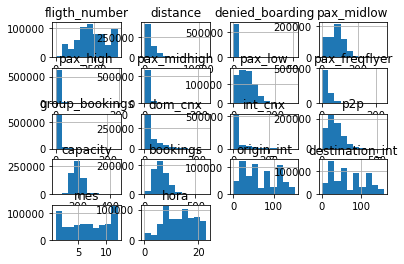

In [49]:
display(pd.DataFrame(df_procesado[target==1].hist()))

In [30]:
df_procesado.drop('out_of_stock', axis=1, inplace=True)

### Se usará K-Fold Cross Validation con Undersampling para calcular los Score
Debido a que las clases se encuentran desbalanceadas, se utilizó una muestra más pequeña de la clase 1 para evitar el overfitting de esa clase.

<module 'matplotlib.pyplot' from '/home/matias/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

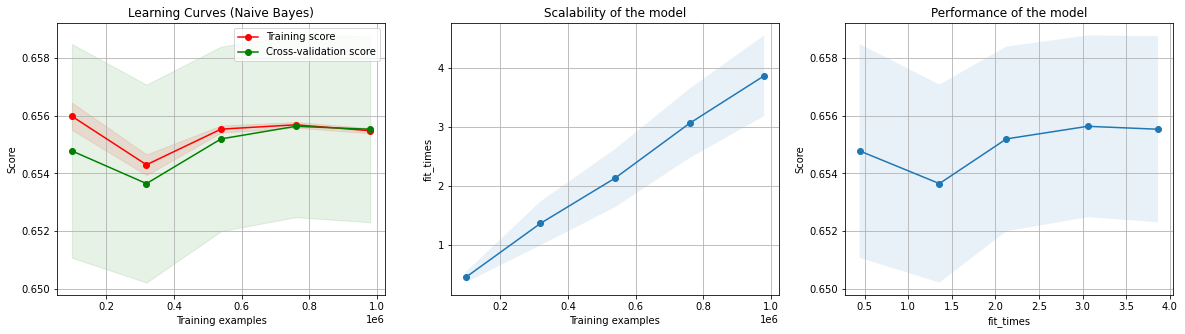

In [46]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

title = "Learning Curves (Naive Bayes)"
cv = KFold(n_splits=50, shuffle = True, random_state=0)
estimator = GaussianNB()
plot_learning_curve(
    estimator, title, df_procesado, target, cv=cv, n_jobs=-1
)


## MultinomialNB (alpha = 0,1,10,100)

In [31]:
TrainF1Score_general = []
TestF1Score_general = []

for j in [0,1,10,100]:
#Crear un objeto de KFold cross validation
    k = 200
    kf = KFold(n_splits = k, shuffle = True)

    NB = MultinomialNB(alpha = j)
    #Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
    F1Train = np.zeros(k)
    F1Test = np.zeros(k)

    i=0
    #Aplicar K-fold cross validation
    for train_index, test_index in kf.split(df_procesado[['origin_int','destination_int','mes','hora']]):
        #extraer los datos de entrenamiento y test
            #Train
            trainData = df_procesado[['origin_int','destination_int','mes','hora']].iloc[train_index, :]
            trainLabel = target.iloc[train_index]

            yes_overbook = trainData[trainLabel == 1]
            no_overbook = trainData[trainLabel == 0]

            yes_overbook = yes_overbook.sample(no_overbook.shape[0])

            trainData = yes_overbook.append(no_overbook)
            trainLabel = pd.Series([1]*no_overbook.shape[0]+[0]*no_overbook.shape[0])

            #Test
            testData = df_procesado[['origin_int','destination_int','mes','hora']].iloc[test_index, :]
            testLabel = target.iloc[test_index]

            #Entrenar el modelo usando los datos de entrenamiento
            NB = NB.fit(trainData, trainLabel)

            #Predecir los valores de TrainData y calcule su error
            prediccion = NB.predict(trainData)
            F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)

            #Prediga los valores de testData y calcule su error
            prediccion = NB.predict(testData)
            F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)

            i+=1

            if(i == k):
                TrainF1Score_general.append(F1Train)
                TestF1Score_general.append(F1Test)

            print(i, end=" ")
    print("F1-score modelo para training: ", TrainF1Score_general[len(TrainF1Score_general)-1].mean(), "+-", TrainF1Score_general[len(TrainF1Score_general)-1].std())   
    print("F1-score modelo para test: ", TestF1Score_general[len(TestF1Score_general)-1].mean(), "+-", TestF1Score_general[len(TestF1Score_general)-1].std())  

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 F1-score modelo para training:  0.5428117657353964 +- 0.00026483396883187585
F1-score modelo para test:  0.44382313421856573 +- 0.009312813585301187
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 

In [16]:
res = [None] * (len(TestF1Score_general))
laplace = [0,1,10,100]
variables = 1
for i in range(len(TestF1Score_general)):
    res[i] = [laplace[i], TrainAcc_general[i].mean(), TrainAcc_general[i].std(), TestAcc_general[i].mean(),TestAcc_general[i].std(), TrainF1Score_general[i].mean(),TrainF1Score_general[i].std(), TestF1Score_general[i].mean(),TestF1Score_general[i].std()]
    variables += 1

resultados = pd.DataFrame(res, columns = ['Laplace','Accuracy Train Mean', 'Accuracy Train Std','Accuracy Test Mean','Accuracy Test Std','F1 Train Mean','F1 Train std','F1 Test Mean','F1 Test Std'])
resultados

NameError: name 'TrainAcc_general' is not defined

No handles with labels found to put in legend.


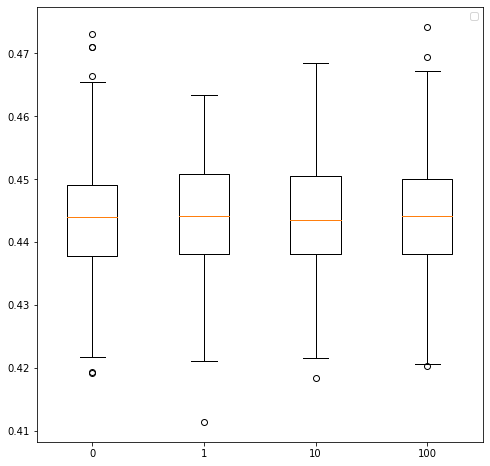

In [32]:
plt.figure(figsize=(8, 8))

plt.boxplot(TestF1Score_general)
plt.xticks([1, 2, 3, 4], ["0","1","10","100"])
plt.legend()
plt.show()

## GaussianNB (alpha = 0,1e-09,1e-05,0.1)

In [42]:
#df_procesado.drop('origin_int', axis=1, inplace=True)
#df_procesado.drop('destination_int', axis=1, inplace=True)ç
len(df_procesado.columns)

19

In [47]:
Gaussian0 = []
Gaussian1 = []
Gaussian2 = []
Gaussian3 = []

m = 1
while(m < len(df_procesado.columns)):
    display(df_procesado.iloc[:,:m])
    TrainF1Score_general = []
    TestF1Score_general = []

    for j in [0,1e-09,1e-05,0.1]:
    #Crear un objeto de KFold cross validation
        k = 100
        kf = KFold(n_splits = k, shuffle = True, random_state = 42)

        NB = GaussianNB(var_smoothing = j)
        #Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
        F1Train = np.zeros(k)
        F1Test = np.zeros(k)

        i=0
        #Aplicar K-fold cross validation
        for train_index, test_index in kf.split(df_procesado.iloc[:,:m]):
            #extraer los datos de entrenamiento y test
                #Train
                trainData = df_procesado.iloc[:,:m].iloc[train_index, :]
                trainLabel = target.iloc[train_index]

                yes_overbook = trainData[trainLabel == 1]
                no_overbook = trainData[trainLabel == 0]

                yes_overbook = yes_overbook.sample(no_overbook.shape[0])

                trainData = yes_overbook.append(no_overbook)
                trainLabel = pd.Series([1]*no_overbook.shape[0]+[0]*no_overbook.shape[0])

                #Test
                testData = df_procesado.iloc[:,:m].iloc[test_index, :]
                testLabel = target.iloc[test_index]

                #Entrenar el modelo usando los datos de entrenamiento
                NB = NB.fit(trainData, trainLabel)

                #Predecir los valores de TrainData y calcule su error
                prediccion = NB.predict(trainData)
                F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)

                #Prediga los valores de testData y calcule su error
                prediccion = NB.predict(testData)
                F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)

                i+=1
                if(i == k):
                    TrainF1Score_general.append(F1Train)
                    TestF1Score_general.append(F1Test)

                print(i, end=" ")
        if j == 0: Gaussian0.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 1: Gaussian1.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 2: Gaussian2.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 3: Gaussian3.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        print("\nF1-score modelo para training: ", TrainF1Score_general[len(TrainF1Score_general)-1].mean(), "+-", TrainF1Score_general[len(TrainF1Score_general)-1].std())   
        print("F1-score modelo para test: ", TestF1Score_general[len(TestF1Score_general)-1].mean(), "+-", TestF1Score_general[len(TestF1Score_general)-1].std())  
    m+=1

,fligth_number
0,3799
1,2869
2,3776
3,2267
4,3051
...,...
999885,2252
999886,2567
999887,3886
999888,3045


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5345158786374943 +- 0.0006043663955304023
F1-score modelo para test:  0.441266750627603 +- 0.005955418130847711
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5346150600005916 +- 0.000578888374715144
F1-score modelo para test:  0.441285926119066 +- 0.005917087828209069
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 

,fligth_number,distance
0,3799,1394
1,2869,489
2,3776,2180
3,2267,524
4,3051,1170
...,...,...
999885,2252,552
999886,2567,3934
999887,3886,1430
999888,3045,1091


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5588307430173622 +- 0.002620548484366393
F1-score modelo para test:  0.4570060084611617 +- 0.006454769713017499
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5583879466676237 +- 0.0025943415260751886
F1-score modelo para test:  0.4568203790358714 +- 0.006391381951132896
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 4

,fligth_number,distance,denied_boarding
0,3799,1394,0
1,2869,489,0
2,3776,2180,0
3,2267,524,0
4,3051,1170,0
...,...,...,...
999885,2252,552,0
999886,2567,3934,0
999887,3886,1430,0
999888,3045,1091,0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.2986939578072344 +- 0.018170695952891107
F1-score modelo para test:  0.27630895843823444 +- 0.018733443162766424
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.3003999623377174 +- 0.019874886329284615
F1-score modelo para test:  0.2780542939666814 +- 0.019974453595579523
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 4

,fligth_number,distance,denied_boarding,pax_midlow
0,3799,1394,0,94
1,2869,489,0,100
2,3776,2180,0,7
3,2267,524,0,54
4,3051,1170,0,21
...,...,...,...,...
999885,2252,552,0,25
999886,2567,3934,0,129
999887,3886,1430,0,2
999888,3045,1091,0,67


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.34044748259833546 +- 0.02488655868655695
F1-score modelo para test:  0.3115627987337824 +- 0.021205553375718354
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.35117162903155547 +- 0.023949361931044633
F1-score modelo para test:  0.31992219661348464 +- 0.01969550331704555
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high
0,3799,1394,0,94,2
1,2869,489,0,100,4
2,3776,2180,0,7,1
3,2267,524,0,54,4
4,3051,1170,0,21,88
...,...,...,...,...,...
999885,2252,552,0,25,12
999886,2567,3934,0,129,3
999887,3886,1430,0,2,1
999888,3045,1091,0,67,2


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.31614794892570375 +- 0.020518889415967457
F1-score modelo para test:  0.2900226127041429 +- 0.01960909658501243
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.3211542423453727 +- 0.01602606271241899
F1-score modelo para test:  0.29430488693319906 +- 0.015422315350276916
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh
0,3799,1394,0,94,2,28
1,2869,489,0,100,4,4
2,3776,2180,0,7,1,5
3,2267,524,0,54,4,7
4,3051,1170,0,21,88,18
...,...,...,...,...,...,...
999885,2252,552,0,25,12,20
999886,2567,3934,0,129,3,19
999887,3886,1430,0,2,1,0
999888,3045,1091,0,67,2,7


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.31718236818094137 +- 0.013873411849376153
F1-score modelo para test:  0.29091307136883293 +- 0.014464820193218817
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.3228763749764802 +- 0.013825648743528157
F1-score modelo para test:  0.2958605702923435 +- 0.015108001802158573
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low
0,3799,1394,0,94,2,28,94
1,2869,489,0,100,4,4,87
2,3776,2180,0,7,1,5,64
3,2267,524,0,54,4,7,21
4,3051,1170,0,21,88,18,82
...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4
999886,2567,3934,0,129,3,19,121
999887,3886,1430,0,2,1,0,108
999888,3045,1091,0,67,2,7,42


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.46189937076033566 +- 0.014299416046263953
F1-score modelo para test:  0.39942741601371035 +- 0.012520185231865228
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.4646760808853734 +- 0.012659534294297413
F1-score modelo para test:  0.40198687300642555 +- 0.011748226781674068
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer
0,3799,1394,0,94,2,28,94,22
1,2869,489,0,100,4,4,87,25
2,3776,2180,0,7,1,5,64,2
3,2267,524,0,54,4,7,21,4
4,3051,1170,0,21,88,18,82,0
...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12
999886,2567,3934,0,129,3,19,121,2
999887,3886,1430,0,2,1,0,108,20
999888,3045,1091,0,67,2,7,42,16


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.48117260682186946 +- 0.00981923420621644
F1-score modelo para test:  0.4153845344166996 +- 0.010108161943430057
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.48051403236855533 +- 0.01017207971449885
F1-score modelo para test:  0.41474044309988756 +- 0.009952343956456134
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings
0,3799,1394,0,94,2,28,94,22,19
1,2869,489,0,100,4,4,87,25,0
2,3776,2180,0,7,1,5,64,2,0
3,2267,524,0,54,4,7,21,4,0
4,3051,1170,0,21,88,18,82,0,88
...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0
999886,2567,3934,0,129,3,19,121,2,20
999887,3886,1430,0,2,1,0,108,20,36
999888,3045,1091,0,67,2,7,42,16,0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.33852119883649434 +- 0.011534289544109629
F1-score modelo para test:  0.3097911674477754 +- 0.013285686544773136
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.339632140929819 +- 0.011515900338971949
F1-score modelo para test:  0.31078508655325754 +- 0.011534515642200488
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx
0,3799,1394,0,94,2,28,94,22,19,1
1,2869,489,0,100,4,4,87,25,0,19
2,3776,2180,0,7,1,5,64,2,0,0
3,2267,524,0,54,4,7,21,4,0,26
4,3051,1170,0,21,88,18,82,0,88,23
...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64
999886,2567,3934,0,129,3,19,121,2,20,0
999887,3886,1430,0,2,1,0,108,20,36,7
999888,3045,1091,0,67,2,7,42,16,0,34


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.34517927827974076 +- 0.011726432369274682
F1-score modelo para test:  0.31480414629861514 +- 0.012009644567297775
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.34767850538541345 +- 0.012316870143751369
F1-score modelo para test:  0.3167664867048978 +- 0.012685848441840555
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx
0,3799,1394,0,94,2,28,94,22,19,1,0
1,2869,489,0,100,4,4,87,25,0,19,9
2,3776,2180,0,7,1,5,64,2,0,0,10
3,2267,524,0,54,4,7,21,4,0,26,0
4,3051,1170,0,21,88,18,82,0,88,23,3
...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9
999886,2567,3934,0,129,3,19,121,2,20,0,118
999887,3886,1430,0,2,1,0,108,20,36,7,0
999888,3045,1091,0,67,2,7,42,16,0,34,2


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.3290937905620679 +- 0.01053633219429525
F1-score modelo para test:  0.30112445552456496 +- 0.012165799517608865
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.3325193149804821 +- 0.011559224203175606
F1-score modelo para test:  0.303940302767453 +- 0.012968365526890955
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p
0,3799,1394,0,94,2,28,94,22,19,1,0,239
1,2869,489,0,100,4,4,87,25,0,19,9,192
2,3776,2180,0,7,1,5,64,2,0,0,10,69
3,2267,524,0,54,4,7,21,4,0,26,0,64
4,3051,1170,0,21,88,18,82,0,88,23,3,183
...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0
999886,2567,3934,0,129,3,19,121,2,20,0,118,156
999887,3886,1430,0,2,1,0,108,20,36,7,0,124
999888,3045,1091,0,67,2,7,42,16,0,34,2,98


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.4546309717411574 +- 0.010907756036396238
F1-score modelo para test:  0.40116408529551906 +- 0.011674412305948265
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.45345478430234576 +- 0.009461362222918946
F1-score modelo para test:  0.3999987377577171 +- 0.010314464337656327
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5338552132395082 +- 0.008238189679924353
F1-score modelo para test:  0.46108141559670435 +- 0.008741640267749835
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5327595725598462 +- 0.006148648722725275
F1-score modelo para test:  0.4602227490387162 +- 0.009031983514483055
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,bookings
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0,240
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0,220
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0,79
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0,90
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0,209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0,73
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0,274
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0,131
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0,134


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5628624278288786 +- 0.004455850843059728
F1-score modelo para test:  0.47948569332759416 +- 0.007567157493797982
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5629187294571286 +- 0.0045613585995585276
F1-score modelo para test:  0.4795984781200539 +- 0.007578528851914507
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0,240,12
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0,220,79
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0,79,122
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0,90,27
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0,209,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0,73,143
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0,274,79
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0,131,62
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0,134,53


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5639728400908642 +- 0.004174116025048244
F1-score modelo para test:  0.4812359277618446 +- 0.007634657087225387
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5649518437789585 +- 0.003918335192414311
F1-score modelo para test:  0.48175551271515227 +- 0.0071221593435386085
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0,240,12,125
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0,220,79,143
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0,79,122,116
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0,90,27,33
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0,209,51,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0,73,143,27
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0,274,79,57
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0,131,62,125
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0,134,53,126


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5652001061647061 +- 0.004012697663930028
F1-score modelo para test:  0.4821282381905752 +- 0.007027664514673488
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5655529126601749 +- 0.003866802713811582
F1-score modelo para test:  0.4824410468222753 +- 0.007868237513095467
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int,revenues_usd_discr
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0,240,12,125,6
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0,220,79,143,2
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0,79,122,116,8
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0,90,27,33,6
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0,209,51,55,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0,73,143,27,8
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0,274,79,57,10
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0,131,62,125,7
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0,134,53,126,5


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5653056645353732 +- 0.003936680259713572
F1-score modelo para test:  0.4829293003294217 +- 0.00711806824903126
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5652463689570001 +- 0.004206067863229097
F1-score modelo para test:  0.48267825186089525 +- 0.007642446037336451
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int,revenues_usd_discr,mes
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0,240,12,125,6,11
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0,220,79,143,2,5
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0,79,122,116,8,5
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0,90,27,33,6,2
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0,209,51,55,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0,73,143,27,8,10
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0,274,79,57,10,5
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0,131,62,125,7,4
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0,134,53,126,5,4


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.5647270667311327 +- 0.004051917629138414
F1-score modelo para test:  0.4826967385769254 +- 0.007151666399762892
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
F1-score modelo para training:  0.565551582766863 +- 0.00419965293005651
F1-score modelo para test:  0.48313906197782985 +- 0.006766462300287652
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 

In [ ]:
plt.figure(figsize=(10, 10))

plt.boxplot(TestF1Score_general)
plt.xticks([1, 2, 3, 4], ["0","1e-09","1e-05","0.1"])
plt.legend()
plt.show()

Límites [1.89864297 0.89864297 0.89784329 ... 0.63922904 0.63917915 0.63911715]


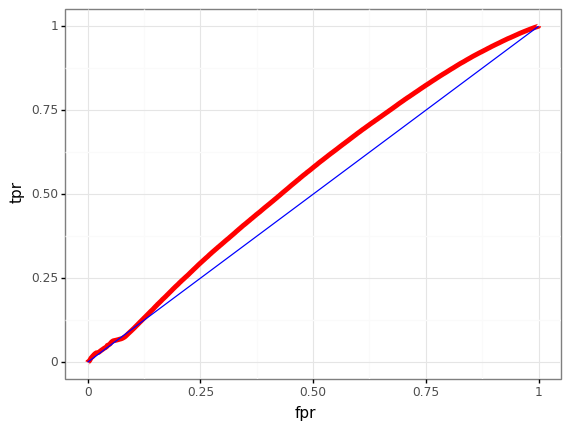


Valor del AUC: 0.5511713414407878


In [25]:
NB.fit(df_procesado, target)
fpr, tpr, thresholds = mt.roc_curve(target, NB.predict_proba(df_procesado)[:,1])
print("Límites",thresholds)

tempDF=pd.DataFrame(zip(fpr,tpr),columns=["fpr","tpr"])
#Curva ROC
print(ggplot(tempDF)+aes(x="fpr",y="tpr")+geom_line(color="red",size=2)+
    annotate("segment",x=0,y=0,xend=1,yend=1,color="blue")+
    theme_bw()
)

#Valor del AUC
print("Valor del AUC:",mt.auc(fpr,tpr))

In [31]:
from sklearn.feature_selection import RFECV

estimator = MultinomialNB(alpha = 10)
selector = RFECV(estimator, cv=5, scoring='f1')
selector = selector.fit(df_procesado[['mes','horario']], target)
display(selector.support_)
display(selector.ranking_)

array([False,  True])

array([2, 1])

In [22]:
#Crear un objeto de KFold cross validation
k = 10
kf = KFold(n_splits = k, shuffle = True)

TrainAcc_general = []
TestAcc_general = []
TrainF1Score_general = []
TestF1Score_general = []

NB = MultinomialNB()

for z in range(1,len(df_procesado.columns)+1):
    display(df_procesado.iloc[:,:z])
    
    df_final = df_procesado.iloc[:,:z]

    #Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
    AccTrain = np.zeros(k)
    AccTest = np.zeros(k)
    F1Train = np.zeros(k)
    F1Test = np.zeros(k)
    
    i=0
    #Aplicar K-fold cross validation
    for train_index, test_index in kf.split(df_final):
        #extraer los datos de entrenamiento y test
            #Train
            trainData = df_procesado.iloc[train_index, :]
            trainLabel = target.iloc[train_index]
        
            yes_overbook = trainData[trainLabel == 1]
            no_overbook = trainData[trainLabel == 0]
            
            yes_overbook = yes_overbook.sample(no_overbook.shape[0])

            trainData = yes_overbook.append(no_overbook)
            trainLabel = pd.Series([1]*no_overbook.shape[0]+[0]*no_overbook.shape[0])
            
            #Test
            testData = df_procesado.iloc[test_index, :]
            testLabel = target.iloc[test_index]

            #Entrenar el modelo usando los datos de entrenamiento
            NB = NB.fit(trainData, trainLabel)

            #Predecir los valores de TrainData y calcule su error
            prediccion = NB.predict(trainData)
            F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)
            AccTrain[i] = mt.accuracy_score(trainLabel, prediccion)

            #Prediga los valores de testData y calcule su error
            prediccion = NB.predict(testData)
            F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)
            AccTest[i] = mt.accuracy_score(testLabel, prediccion)

            i+=1
            
            if(i == k):
                TrainAcc_general.append(AccTrain)
                TestAcc_general.append(AccTest)
                TrainF1Score_general.append(F1Train)
                TestF1Score_general.append(F1Test)

            print(i, end=" ")
            
    print("\nAccuracy-score modelo para training: ", TrainAcc_general[len(TrainAcc_general)-1].mean(), "+-", TrainAcc_general[len(TrainAcc_general)-1].std()) 
    print("Accuracy-score modelo para test: ", TestAcc_general[len(TestAcc_general)-1].mean(), "+-", TestAcc_general[len(TestAcc_general)-1].std())
    print("F1-score modelo para training: ", TrainF1Score_general[len(TrainF1Score_general)-1].mean(), "+-", TrainF1Score_general[len(TrainF1Score_general)-1].std())   
    print("F1-score modelo para test: ", TestF1Score_general[len(TestF1Score_general)-1].mean(), "+-", TestF1Score_general[len(TestF1Score_general)-1].std())  

,fligth_number
0,3799
1,2869
2,3776
3,2267
4,3051
...,...
999885,2252
999886,2567
999887,3886
999888,3045


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.541159593113233 +- 0.00037071206255074094
Accuracy-score modelo para test:  0.5896653482382802 +- 0.001492153549371885
F1-score modelo para training:  0.4560983194126861 +- 0.0004773155371474363
F1-score modelo para test:  0.3926199997115269 +- 0.0025474155124093423


,fligth_number,distance
0,3799,1394
1,2869,489
2,3776,2180
3,2267,524
4,3051,1170
...,...,...
999885,2252,552
999886,2567,3934
999887,3886,1430
999888,3045,1091


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5411883617786094 +- 0.00030269362080275077
Accuracy-score modelo para test:  0.5896883517387964 +- 0.0013000667070832577
F1-score modelo para training:  0.4560492297408995 +- 0.00038244371155618664
F1-score modelo para test:  0.3925602775160961 +- 0.002465317209175567


,fligth_number,distance,pax_midlow
0,3799,1394,94
1,2869,489,100
2,3776,2180,7
3,2267,524,54
4,3051,1170,21
...,...,...,...
999885,2252,552,25
999886,2567,3934,129
999887,3886,1430,2
999888,3045,1091,67


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5411648135743634 +- 0.00027067217263516605
Accuracy-score modelo para test:  0.5897283563793325 +- 0.0010688342119547598
F1-score modelo para training:  0.45603193932298713 +- 0.0003520572316400479
F1-score modelo para test:  0.3925496069536444 +- 0.002152110542032665


,fligth_number,distance,pax_midlow,pax_high
0,3799,1394,94,2
1,2869,489,100,4
2,3776,2180,7,1
3,2267,524,54,4
4,3051,1170,21,88
...,...,...,...,...
999885,2252,552,25,12
999886,2567,3934,129,3
999887,3886,1430,2,1
999888,3045,1091,67,2


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5409382707151585 +- 0.00036558203977129437
Accuracy-score modelo para test:  0.5896973539091985 +- 0.0020518226108861204
F1-score modelo para training:  0.45583668117732723 +- 0.0004932537040638998
F1-score modelo para test:  0.39251486691169485 +- 0.0021228382678391113


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh
0,3799,1394,94,2,28
1,2869,489,100,4,4
2,3776,2180,7,1,5
3,2267,524,54,4,7
4,3051,1170,21,88,18
...,...,...,...,...,...
999885,2252,552,25,12,20
999886,2567,3934,129,3,19
999887,3886,1430,2,1,0
999888,3045,1091,67,2,7


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.541098636671287 +- 0.0003648676212780872
Accuracy-score modelo para test:  0.5896973534090735 +- 0.0011357838788723716
F1-score modelo para training:  0.4559965497150718 +- 0.000563123080527519
F1-score modelo para test:  0.39252879957767345 +- 0.002428015013138715


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low
0,3799,1394,94,2,28,94
1,2869,489,100,4,4,87
2,3776,2180,7,1,5,64
3,2267,524,54,4,7,21
4,3051,1170,21,88,18,82
...,...,...,...,...,...,...
999885,2252,552,25,12,20,4
999886,2567,3934,129,3,19,121
999887,3886,1430,2,1,0,108
999888,3045,1091,67,2,7,42


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5411230786334601 +- 0.0003714274565515079
Accuracy-score modelo para test:  0.5897573597997352 +- 0.0013485351681373414
F1-score modelo para training:  0.4558935191158885 +- 0.00044898776302896236
F1-score modelo para test:  0.392456413849119 +- 0.003009041979067814


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer
0,3799,1394,94,2,28,94,22
1,2869,489,100,4,4,87,25
2,3776,2180,7,1,5,64,2
3,2267,524,54,4,7,21,4
4,3051,1170,21,88,18,82,0
...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12
999886,2567,3934,129,3,19,121,2
999887,3886,1430,2,1,0,108,20
999888,3045,1091,67,2,7,42,16


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.541101143812291 +- 0.0001787102335041312
Accuracy-score modelo para test:  0.5897153575598304 +- 0.0011010450579850483
F1-score modelo para training:  0.45593159741994416 +- 0.00024158061063544675
F1-score modelo para test:  0.392463609733102 +- 0.0019489758536125235


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings
0,3799,1394,94,2,28,94,22,19
1,2869,489,100,4,4,87,25,0
2,3776,2180,7,1,5,64,2,0
3,2267,524,54,4,7,21,4,0
4,3051,1170,21,88,18,82,0,88
...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0
999886,2567,3934,129,3,19,121,2,20
999887,3886,1430,2,1,0,108,20,36
999888,3045,1091,67,2,7,42,16,0


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.54115203713646 +- 0.0002967555932054137
Accuracy-score modelo para test:  0.5897313569794356 +- 0.0015152958045839319
F1-score modelo para training:  0.45594289593418774 +- 0.0003613466484290271
F1-score modelo para test:  0.39251936938823506 +- 0.0031812113662527844


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock
0,3799,1394,94,2,28,94,22,19,0
1,2869,489,100,4,4,87,25,0,0
2,3776,2180,7,1,5,64,2,0,0
3,2267,524,54,4,7,21,4,0,0
4,3051,1170,21,88,18,82,0,88,1
...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0
999886,2567,3934,129,3,19,121,2,20,0
999887,3886,1430,2,1,0,108,20,36,0
999888,3045,1091,67,2,7,42,16,0,0


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5410106417717728 +- 0.00036137160778248464
Accuracy-score modelo para test:  0.589685348257973 +- 0.0019444918207612225
F1-score modelo para training:  0.45596264123127794 +- 0.00044003434128344113
F1-score modelo para test:  0.39257356895122425 +- 0.0015073284042309352


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx
0,3799,1394,94,2,28,94,22,19,0,1
1,2869,489,100,4,4,87,25,0,0,19
2,3776,2180,7,1,5,64,2,0,0,0
3,2267,524,54,4,7,21,4,0,0,26
4,3051,1170,21,88,18,82,0,88,1,23
...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64
999886,2567,3934,129,3,19,121,2,20,0,0
999887,3886,1430,2,1,0,108,20,36,0,7
999888,3045,1091,67,2,7,42,16,0,0,34


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5410660518175631 +- 0.0004919135942490657
Accuracy-score modelo para test:  0.5897073571598552 +- 0.0016360888557277878
F1-score modelo para training:  0.455935397430505 +- 0.00047059528719702075
F1-score modelo para test:  0.3924717094716016 +- 0.002336714132717168


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx
0,3799,1394,94,2,28,94,22,19,0,1,0
1,2869,489,100,4,4,87,25,0,0,19,9
2,3776,2180,7,1,5,64,2,0,0,0,10
3,2267,524,54,4,7,21,4,0,0,26,0
4,3051,1170,21,88,18,82,0,88,1,23,3
...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9
999886,2567,3934,129,3,19,121,2,20,0,0,118
999887,3886,1430,2,1,0,108,20,36,0,7,0
999888,3045,1091,67,2,7,42,16,0,0,34,2


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5411709975631402 +- 0.00034744218871532424
Accuracy-score modelo para test:  0.5896583495087069 +- 0.0013911664844393865
F1-score modelo para training:  0.4561347758108284 +- 0.0004920466937660793
F1-score modelo para test:  0.392642739645385 +- 0.002696282944531716


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p
0,3799,1394,94,2,28,94,22,19,0,1,0,239
1,2869,489,100,4,4,87,25,0,0,19,9,192
2,3776,2180,7,1,5,64,2,0,0,0,10,69
3,2267,524,54,4,7,21,4,0,0,26,0,64
4,3051,1170,21,88,18,82,0,88,1,23,3,183
...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9,0
999886,2567,3934,129,3,19,121,2,20,0,0,118,156
999887,3886,1430,2,1,0,108,20,36,0,7,0,124
999888,3045,1091,67,2,7,42,16,0,0,34,2,98


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5411789826802059 +- 0.0002242422105765669
Accuracy-score modelo para test:  0.5896883503284438 +- 0.0013768176772139405
F1-score modelo para training:  0.4560245989024139 +- 0.0003123664997283522
F1-score modelo para test:  0.39254937233612247 +- 0.002235089595177331


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,origin_int
0,3799,1394,94,2,28,94,22,19,0,1,0,239,12
1,2869,489,100,4,4,87,25,0,0,19,9,192,79
2,3776,2180,7,1,5,64,2,0,0,0,10,69,122
3,2267,524,54,4,7,21,4,0,0,26,0,64,27
4,3051,1170,21,88,18,82,0,88,1,23,3,183,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9,0,143
999886,2567,3934,129,3,19,121,2,20,0,0,118,156,79
999887,3886,1430,2,1,0,108,20,36,0,7,0,124,62
999888,3045,1091,67,2,7,42,16,0,0,34,2,98,53


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5411370036181482 +- 0.00016675245464694975
Accuracy-score modelo para test:  0.5896403452179151 +- 0.000929228731565966
F1-score modelo para training:  0.45606093113242385 +- 0.00025796395051387794
F1-score modelo para test:  0.3925091967953988 +- 0.0029251689003365728


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,origin_int,destination_int
0,3799,1394,94,2,28,94,22,19,0,1,0,239,12,125
1,2869,489,100,4,4,87,25,0,0,19,9,192,79,143
2,3776,2180,7,1,5,64,2,0,0,0,10,69,122,116
3,2267,524,54,4,7,21,4,0,0,26,0,64,27,33
4,3051,1170,21,88,18,82,0,88,1,23,3,183,51,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9,0,143,27
999886,2567,3934,129,3,19,121,2,20,0,0,118,156,79,57
999887,3886,1430,2,1,0,108,20,36,0,7,0,124,62,125
999888,3045,1091,67,2,7,42,16,0,0,34,2,98,53,126


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5410322478014097 +- 0.00020399944526441953
Accuracy-score modelo para test:  0.5897213580998718 +- 0.0013145870991886216
F1-score modelo para training:  0.45590412294362803 +- 0.00022859400994074637
F1-score modelo para test:  0.39252570352895544 +- 0.0030613860709977157


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,origin_int,destination_int,capacidad
0,3799,1394,94,2,28,94,22,19,0,1,0,239,12,125,2
1,2869,489,100,4,4,87,25,0,0,19,9,192,79,143,2
2,3776,2180,7,1,5,64,2,0,0,0,10,69,122,116,3
3,2267,524,54,4,7,21,4,0,0,26,0,64,27,33,2
4,3051,1170,21,88,18,82,0,88,1,23,3,183,51,55,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9,0,143,27,2
999886,2567,3934,129,3,19,121,2,20,0,0,118,156,79,57,2
999887,3886,1430,2,1,0,108,20,36,0,7,0,124,62,125,3
999888,3045,1091,67,2,7,42,16,0,0,34,2,98,53,126,2


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5411343555579871 +- 0.00040561400736915726
Accuracy-score modelo para test:  0.5896723515389961 +- 0.0015065424224033155
F1-score modelo para training:  0.45603524049470545 +- 0.00046890905462492464
F1-score modelo para test:  0.39253290706276234 +- 0.0019626010752606623


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,origin_int,destination_int,capacidad,denied
0,3799,1394,94,2,28,94,22,19,0,1,0,239,12,125,2,1
1,2869,489,100,4,4,87,25,0,0,19,9,192,79,143,2,1
2,3776,2180,7,1,5,64,2,0,0,0,10,69,122,116,3,1
3,2267,524,54,4,7,21,4,0,0,26,0,64,27,33,2,1
4,3051,1170,21,88,18,82,0,88,1,23,3,183,51,55,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9,0,143,27,2,1
999886,2567,3934,129,3,19,121,2,20,0,0,118,156,79,57,2,1
999887,3886,1430,2,1,0,108,20,36,0,7,0,124,62,125,3,1
999888,3045,1091,67,2,7,42,16,0,0,34,2,98,53,126,2,1


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.541142682171935 +- 0.0002815449367615648
Accuracy-score modelo para test:  0.5897513598998538 +- 0.0017892198882229504
F1-score modelo para training:  0.4559545355912974 +- 0.0004947171952713064
F1-score modelo para test:  0.39251623237531597 +- 0.0025846577409385976


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,origin_int,destination_int,capacidad,denied,booking
0,3799,1394,94,2,28,94,22,19,0,1,0,239,12,125,2,1,3
1,2869,489,100,4,4,87,25,0,0,19,9,192,79,143,2,1,3
2,3776,2180,7,1,5,64,2,0,0,0,10,69,122,116,3,1,1
3,2267,524,54,4,7,21,4,0,0,26,0,64,27,33,2,1,1
4,3051,1170,21,88,18,82,0,88,1,23,3,183,51,55,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9,0,143,27,2,1,1
999886,2567,3934,129,3,19,121,2,20,0,0,118,156,79,57,2,1,3
999887,3886,1430,2,1,0,108,20,36,0,7,0,124,62,125,3,1,2
999888,3045,1091,67,2,7,42,16,0,0,34,2,98,53,126,2,1,2


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5409473098160259 +- 0.0002234617290064449
Accuracy-score modelo para test:  0.5897593600197589 +- 0.0015092128470137055
F1-score modelo para training:  0.455809341693171 +- 0.00031887236962291
F1-score modelo para test:  0.3925133778903051 +- 0.0025006933862744356


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,origin_int,destination_int,capacidad,denied,booking,revenues_usd_discr
0,3799,1394,94,2,28,94,22,19,0,1,0,239,12,125,2,1,3,6
1,2869,489,100,4,4,87,25,0,0,19,9,192,79,143,2,1,3,2
2,3776,2180,7,1,5,64,2,0,0,0,10,69,122,116,3,1,1,8
3,2267,524,54,4,7,21,4,0,0,26,0,64,27,33,2,1,1,6
4,3051,1170,21,88,18,82,0,88,1,23,3,183,51,55,2,1,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9,0,143,27,2,1,1,8
999886,2567,3934,129,3,19,121,2,20,0,0,118,156,79,57,2,1,3,10
999887,3886,1430,2,1,0,108,20,36,0,7,0,124,62,125,3,1,2,7
999888,3045,1091,67,2,7,42,16,0,0,34,2,98,53,126,2,1,2,5


1 2 3 4 

KeyboardInterrupt: 

In [32]:
res = [None] * (len(TestF1Score_general))

variables = 1
for i in range(len(TestF1Score_general)):
    res[i] = [variables, TrainAcc_general[i].mean(), TrainAcc_general[i].std(), TestAcc_general[i].mean(),TestAcc_general[i].std(), TrainF1Score_general[i].mean(),TrainF1Score_general[i].std(), TestF1Score_general[i].mean(),TestF1Score_general[i].std()]
    variables += 1

resultados = pd.DataFrame(res, columns = ['# Variables','Accuracy Train Mean', 'Accuracy Train Std','Accuracy Test Mean','Accuracy Test Std','F1 Train Mean','F1 Train std','F1 Test Mean','F1 Test Std'])
resultados

,# Variables,Accuracy Train Mean,Accuracy Train Std,Accuracy Test Mean,Accuracy Test Std,F1 Train Mean,F1 Train std,F1 Test Mean,F1 Test Std
0,1,0.588093,0.000473,0.576696,0.002059,0.602283,0.001557,0.503873,0.001902
1,2,0.588172,0.000446,0.577798,0.002711,0.601580,0.001790,0.503824,0.001513
2,3,0.587856,0.000652,0.576927,0.002319,0.601843,0.001667,0.503744,0.001788
3,4,0.587915,0.000447,0.577036,0.002838,0.602083,0.001728,0.504142,0.001485
4,5,0.587961,0.000333,0.577385,0.002226,0.601671,0.001623,0.503848,0.001043
5,6,0.588119,0.000373,0.577618,0.002004,0.601585,0.001486,0.503784,0.001703
6,7,0.587749,0.000345,0.576664,0.002242,0.602165,0.001219,0.504011,0.001566
7,8,0.588221,0.000635,0.577555,0.002009,0.601711,0.001661,0.503700,0.001869
8,9,0.588168,0.000408,0.578183,0.002359,0.601081,0.001325,0.503475,0.001945
9,10,0.587987,0.000459,0.576515,0.002455,0.602437,0.001273,0.503974,0.001603


<Figure size 720x720 with 0 Axes>

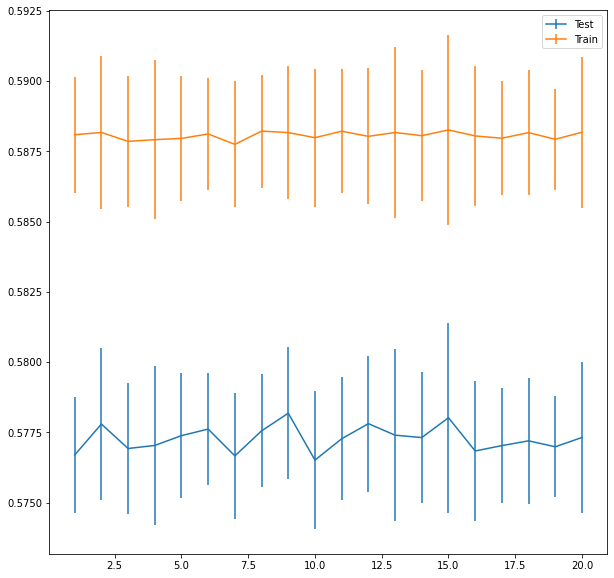

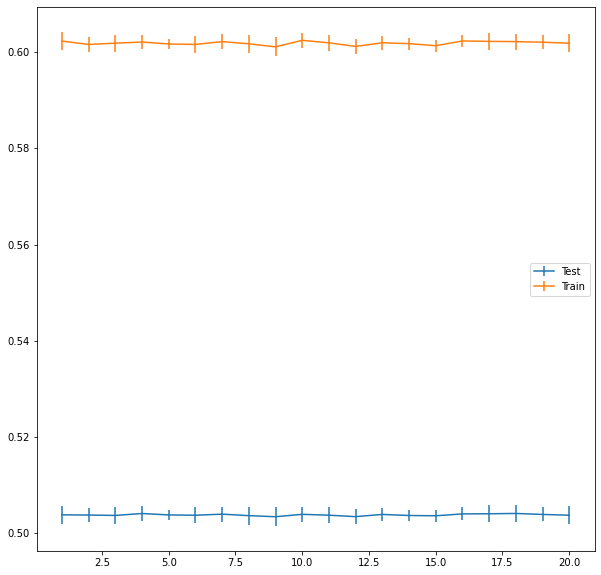

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

plt.figure(figsize=(10, 10))
plt.errorbar(resultados["# Variables"], resultados["Accuracy Test Mean"], resultados["Accuracy Test Std"], label = "Test")
plt.errorbar(resultados["# Variables"], resultados["Accuracy Train Mean"], resultados["Accuracy Test Std"], label = "Train")
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.errorbar(resultados["# Variables"], resultados["F1 Test Mean"], resultados["F1 Test Std"], label = "Test")
plt.errorbar(resultados["# Variables"], resultados["F1 Train Mean"], resultados["F1 Test Std"], label = "Train")
plt.legend()
plt.show()

GaussianNB()
Límites [2.00000000e+000 1.00000000e+000 9.99999999e-001 ... 6.63175514e-069
 3.02472253e-074 1.29073015e-122]


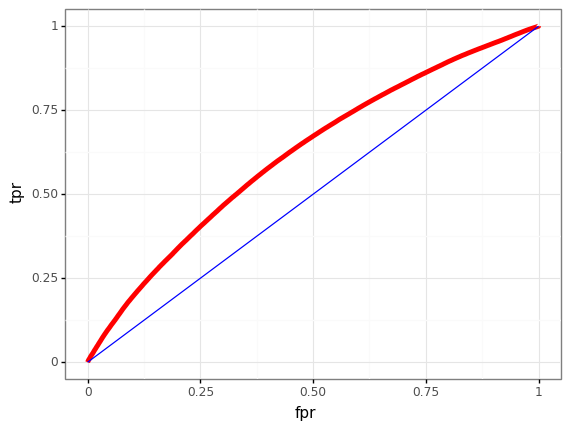


Valor del AUC: 0.619323826709399
ComplementNB()
Límites [2.e+000 1.e+000 1.e+000 ... 1.e-323 5.e-324 0.e+000]


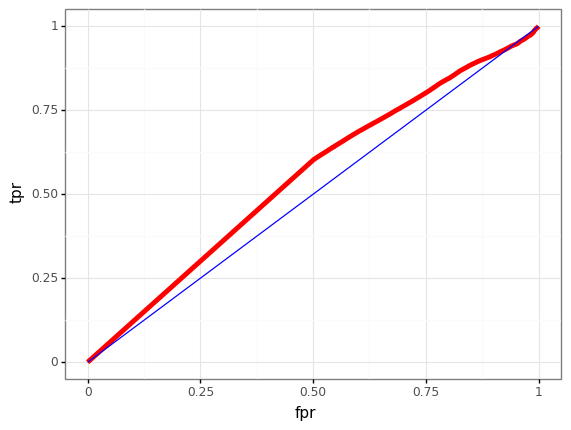


Valor del AUC: 0.5506882314787327
CategoricalNB()
Límites [1.99999823e+00 9.99998229e-01 9.99983528e-01 ... 4.55622294e-05
 4.33112110e-05 4.60607485e-06]


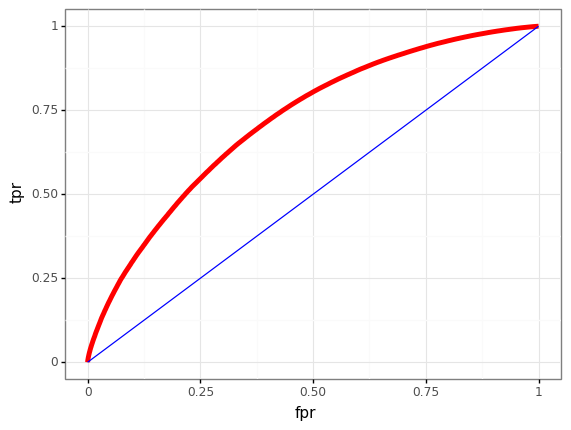


Valor del AUC: 0.7180869977576574
MultinomialNB()
Límites [2.e+000 1.e+000 1.e+000 ... 1.e-323 5.e-324 0.e+000]


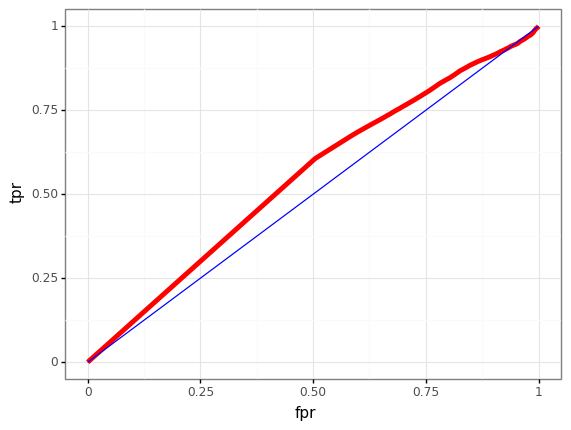


Valor del AUC: 0.5504662841528888


In [42]:
from sklearn import metrics as mt
#df_final = df_procesado[columnas.Variable].iloc[:,:i]
#Calculando los tpr and fpr
NaiveBayes = [GaussianNB(), ComplementNB(), CategoricalNB(), MultinomialNB()]
for i in NaiveBayes:
    NB = i
    print(i)
    NB.fit(df_procesado, target)
    fpr, tpr, thresholds = mt.roc_curve(target, NB.predict_proba(df_procesado)[:,1])
    print("Límites",thresholds)

    tempDF=pd.DataFrame(zip(fpr,tpr),columns=["fpr","tpr"])
    #Curva ROC
    print(ggplot(tempDF)+aes(x="fpr",y="tpr")+geom_line(color="red",size=2)+
        annotate("segment",x=0,y=0,xend=1,yend=1,color="blue")+
        theme_bw()
    )

    #Valor del AUC
    print("Valor del AUC:",mt.auc(fpr,tpr))

In [40]:
df_procesado[['distance', 'pax_midlow', 'pax_high', 'pax_midhigh','pax_low', 'pax_freqflyer', 'group_bookings', 'out_of_stock', 'dom_cnx','int_cnx', 'p2p']]

,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p
0,1394,94,2,28,94,22,19,0,1,0,239
1,489,100,4,4,87,25,0,0,19,9,192
2,2180,7,1,5,64,2,0,0,0,10,69
3,524,54,4,7,21,4,0,0,26,0,64
4,1170,21,88,18,82,0,88,1,23,3,183
...,...,...,...,...,...,...,...,...,...,...,...
999885,552,25,12,20,4,12,0,0,64,9,0
999886,3934,129,3,19,121,2,20,0,0,118,156
999887,1430,2,1,0,108,20,36,0,7,0,124
999888,1091,67,2,7,42,16,0,0,34,2,98


In [110]:
res = [None] * (len(TestF1Score_general))

variables = [0,1e-09,1e-05,0.1]
for i in range(len(TestF1Score_general)):
    res[i] = [variables[i], TrainF1Score_general[i],TrainF1Score_general[i], TestF1Score_general[i].mean(),TestF1Score_general[i].std()]

resultados = pd.DataFrame(res, columns = ['Var_Smooth','Accuracy Train Mean', 'Accuracy Train Std','Accuracy Test Mean','Accuracy Test Std','F1 Train Mean','F1 Train std','F1 Test Mean','F1 Test Std'])
resultados

ValueError: 9 columns passed, passed data had 5 columns

# Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

#Crear un objeto de KFold cross validation

#for k in range (2,100, 5):
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

#Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
F1Train = np.zeros(5)
F1Test = np.zeros(5)

LR = LogisticRegression(max_iter = 2000)
i=0

#Aplicar K-fold cross validation
for train_index, test_index in kf.split(df_procesado):
        #extraer los datos de entrenamiento y test
        trainData = df_procesado.iloc[train_index, :]
        testData = df_procesado.iloc[test_index, :]

        trainLabel = target.iloc[train_index]
        testLabel = target.iloc[test_index]

        #Entrenar el modelo usando los datos de entrenamiento
        LR = LR.fit(trainData, trainLabel)
        
        #Predecir los valores de TrainData y calcule su error
        prediccion = LR.predict(trainData)
        F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)
    
        #Prediga los valores de testData y calcule su error
        prediccion = LR.predict(testData)
        F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)

        i+=1

        print(i, end = " ")
print("\nF1-score modelo para training: ", F1Train.mean(), "+-", F1Train.std())   
print("F1-score modelo para test: ", F1Test.mean(), "+-", F1Test.std())  

1 2 3 4 5 
F1-score modelo para training:  0.10186918570694592 +- 0.0057630979067868
F1-score modelo para test:  0.10173555250847224 +- 0.005514475847260418


Límites [1.92780458 0.92780458 0.9179111  ... 0.04342799 0.04300224 0.02239531]


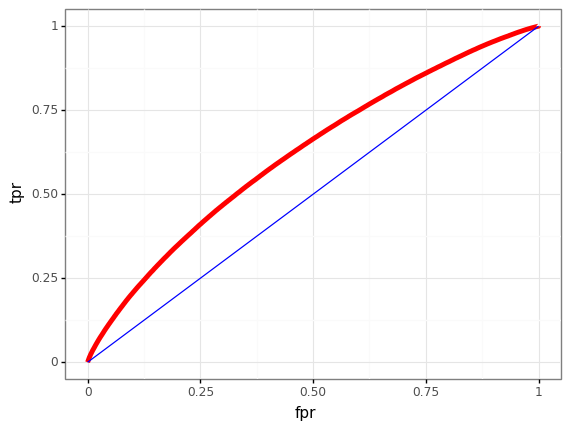


Valor del AUC: 0.6202874284252193


In [35]:
#Calculando los tpr and fpr
from sklearn import metrics as mt
fpr, tpr, thresholds = mt.roc_curve(target, LR.predict_proba(df_procesado)[:,1])
print("Límites",thresholds)

tempDF=pd.DataFrame(zip(fpr,tpr),columns=["fpr","tpr"])
#Curva ROC
print(ggplot(tempDF)+aes(x="fpr",y="tpr")+geom_line(color="red",size=2)+
    annotate("segment",x=0,y=0,xend=1,yend=1,color="blue")+
    theme_bw()
)

#Valor del AUC
print("Valor del AUC:",mt.auc(fpr,tpr))

In [79]:
def procesar_csv(df):
    from sklearn import preprocessing
    
    # Convertirmos las columnas origin y destination a variables numericas 
    le = preprocessing.LabelEncoder()
    ciudades = ((pd.concat([df['origin'], df['destination']], ignore_index = True).drop_duplicates()).reset_index())[0]
    le.fit(ciudades)
    
    origin_as_int = le.fit_transform(df['origin'])
    destination_as_int = le.fit_transform(df["destination"])
    
    df["origin_int"] = origin_as_int
    df.drop('origin', axis=1, inplace=True)
    
    df["destination_int"] = destination_as_int
    df.drop('destination', axis=1, inplace=True)

    df["p2p"] = np.where(df["p2p"] > 0, 1,0)
    df["pax_midlow"] = np.where(df["pax_midlow"] > 0, 1,0)
    df["pax_high"] = np.where(df["pax_high"] > 0, 1,0)
    df["pax_midhigh"] = np.where(df["pax_midhigh"] > 0, 1,0)
    df["pax_low"] = np.where(df["pax_low"] > 0, 1,0)
    df["pax_freqflyer"] = np.where(df["pax_freqflyer"] > 0, 1,0)
    df["group_bookings"] = np.where(df["group_bookings"] > 0, 1,0)
    df["dom_cnx"] = np.where(df["dom_cnx"] > 0, 1,0)
    df["int_cnx"] = np.where(df["int_cnx"] > 0, 1,0)
    
    
    # Transformamos Columnas Continuas a Discretas
    revenues_usd_discr = pd.qcut(df["revenues_usd"], 10, [1,2,3,4,5,6,7,8,9,10] )
    df["revenues_usd_discr"] = revenues_usd_discr
    df.drop('revenues_usd', axis=1, inplace=True)
    
    # Cambiamos el formato del date y departure_time para saber el mes de la compra y el horario en el que se compra
    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    df["mes"] = pd.DatetimeIndex(df["date"]).month
    
    df.departure_time = pd.to_datetime(df.departure_time, errors='coerce')
    bins = [0,12,18,24]
    labels = [1,2,3]
    df['horario'] = pd.cut(df["departure_time"].dt.hour, bins, labels=labels, right=False)
    
    
    df.drop('departure_time', axis=1, inplace=True)
    df.drop('date', axis=1, inplace=True)
    
    # Eliminar columnas sin uso
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # retornamos el data frame modificado sin valore nulos.
    return df.dropna()

In [6]:
from sklearn.feature_selection import RFECV
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB(alpha=10)

selector = RFECV(NB, step=1, cv=10,scoring='f1')
selector = selector.fit(df_procesado, target)

resultados = [None] * 20

for k in range(20):
    resultados[k] = df_procesado.columns[k],selector.support_[k],selector.ranking_[k]

columnas = pd.DataFrame(resultados, columns = ['Variable','Support', 'Ranking'])
columnas = columnas.sort_values(by=['Ranking'])
columnas

,Variable,Support,Ranking
8,out_of_stock,True,1
19,horario,False,2
15,denied,False,3
16,booking,False,4
14,capacidad,False,5
7,group_bookings,False,6
3,pax_high,False,7
17,revenues_usd_discr,False,8
4,pax_midhigh,False,9
18,mes,False,10


Optimal number of features : 1


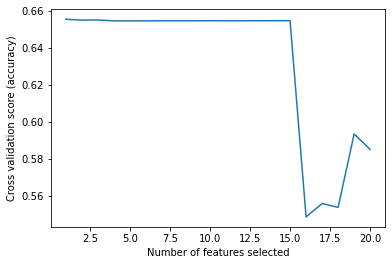

In [81]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification


# Create the RFE object and compute a cross-validated score.
NB = MultinomialNB(alpha = 100)
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=NB,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(df_procesado, target)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [24]:
from sklearn.feature_selection import RFE

#for k in range (2,100, 5):
kf = KFold(n_splits = 2, shuffle = True, random_state = 42)

NB = MultinomialNB(alpha = 10)
i=0

#Aplicar K-fold cross validation
for train_index, test_index in kf.split(df_procesado):
    
        #extraer los datos de entrenamiento y test
        trainData = df_procesado.iloc[train_index, :]
        trainLabel = target.iloc[train_index]

        yes_overbook = trainData[trainLabel == 1]
        no_overbook = trainData[trainLabel == 0]

        yes_overbook = yes_overbook.sample(no_overbook.shape[0])

        trainData = yes_overbook.append(no_overbook)
        trainLabel = pd.Series([1]*no_overbook.shape[0]+[0]*no_overbook.shape[0])

        testData = df_procesado.iloc[test_index, :]
        testLabel = target.iloc[test_index]

        rfe = RFE(NB)
        rfe = rfe.fit(trainData, trainLabel)
        i+=1

resultados = [None] * 20

for k in range(20):
    resultados[k] = df_procesado.columns[k],rfe.support_[k],rfe.ranking_[k]

columnas = pd.DataFrame(resultados, columns = ['Variable','Support', 'Ranking'])
columnas = columnas.sort_values(by=['Ranking'])
columnas

,Variable,Support,Ranking
19,horario,True,1
17,revenues_usd_discr,True,1
16,booking,True,1
3,pax_high,True,1
4,pax_midhigh,True,1
15,denied,True,1
7,group_bookings,True,1
8,out_of_stock,True,1
18,mes,True,1
14,capacidad,True,1
